# Environmental sustainability of digital content consumption

### LCA results analysis

In [1]:
import brightway2 as bw
import bw2analyzer as ba
import presamples as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from pathlib import Path

# Run functions to perform LCIA and contribution analysis
%run _Functions_for_results_analysis.ipynb

## 0 Basic set-up

In [2]:
PROJECT_NAME = 'iri' # <- insert your project name here
bw.projects.set_current(PROJECT_NAME)

DATA_DIR = Path("../data")

In [3]:
# Databases used
DBS = {
       'Ecoinvent':            'ecoinvent 3.8 cutoff',
       'Ecoinvent Base 2030':  'ecoinvent 3.8 cutoff, IMAGE SSP2-Base, 2030',
       'Ecoinvent RCP26 2030': 'ecoinvent 3.8 cutoff, IMAGE SSP2-RCP26, 2030',
       'Ecoinvent RCP19 2030': 'ecoinvent 3.8 cutoff, IMAGE SSP2-RCP19, 2030',

       'Digital content':                    'internet-environmental-footprint',
       'Digital content Wind data centres':  'internet-environmental-footprint, data centres powered by wind',
       'Digital content Solar data centres': 'internet-environmental-footprint, data centres powered by solar PV',

       'Digital content Base 2030': 'internet-environmental-footprint, IMAGE SSP2-Base, 2030',
       'Digital content RCP26 2030': 'internet-environmental-footprint, IMAGE SSP2-RCP26, 2030',
       'Digital content RCP19 2030': 'internet-environmental-footprint, IMAGE SSP2-RCP19, 2030',
      }

# LCIA methods
LCIA_METHODS = {
                'Carbon footprint':                 ('IPCC 2021', 'climate change: including SLCFs', 'GWP 100a, incl. H and bio CO2'),

                'Climate change':                   ('IPCC 2021', 'climate change: CO2 emissions'),
                'Acidification':                    ('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
                'Eutrophication, freshwater':       ('EF v3.0', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
                'Eutrophication, marine':           ('EF v3.0', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'),
                'Eutrophication, terrestrial':      ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
                'Photochemical ozone formation':    ('EF v3.0', 'photochemical ozone formation: human health', 'tropospheric ozone concentration increase'),
                'Particulate matter formation':     ('EF v3.0', 'particulate matter formation', 'impact on human health'),
                'Ozone depletion':                  ('EF v3.0', 'ozone depletion', 'ozone depletion potential (ODP) '),
                'Ecotoxicity, freshwater':          ('EF v3.1 adapted to biosphere ei38', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'),
                'Human toxicity, carcinogenic':     ('EF v3.1 adapted to biosphere ei38', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Human toxicity, non-carcinogenic': ('EF v3.1 adapted to biosphere ei38', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Ionising radiation':               ('EF v3.0', 'ionising radiation: human health', 'human exposure efficiency relative to u235'), 
                'Resource use, fossils':            ('EF v3.0', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
                'Resource use, mineral and metals': ('EF v3.0', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
                'Land use, soil erosion':           ('LANCA v2.5 - land use', 'erosion potential'),
                'Freshwater use':                   ('selected LCI results, additional', 'resource', 'water')
               }

CF_MEHOD = {k:v for (k,v) in LCIA_METHODS.items() if k == 'Carbon footprint'}

# Assessed locations
LOCATIONS = {
             'GLO': 'World', 
             'BR': 'Brazil', 
             'CA': 'Canada',
             'CN': 'China',
             'IN': 'India',
             'US': 'United States',
             'NO': 'Norway',
             'CH': 'Switzerland',
             'FR': 'France',
             'DK': 'Denmark',
             'ES': 'Spain',
             'IT': 'Italy',
             'DE': 'Germany',
             'PL': 'Poland',
             'GB': 'United Kingdom',
             'ZA': 'South Africa',
             'AU': 'Australia',
             'RU': 'Russia'
             }

In [4]:
# Import per capita carrying capacities for EF indicators
carrying_capacity_per_capita = pd.read_excel(Path(r"..\data\LCIA_Carrying-Capacities.xlsx"), index_col=0)
carrying_capacity_per_capita.head()

,Unit,carrying_capacity_2020,carrying_capacity_2030
Impact category,,,
Climate change,kg CO2/person/year,500.563828,500.563828
Acidification,mol H+-eq/person/year,128.290676,116.979760
"Eutrophication, freshwater",kg P-eq/person/year,0.745317,0.679605
"Eutrophication, marine",kg N-eq/person/year,2.989173,2.725628
"Eutrophication, terrestrial",mol N-eq/person/year,786.421845,717.085928


In [5]:
# IDs used:
USERS = ['Medium technology user',
         'Low technology user',         # for sensitivity analysis on user consumption patterns
         'High technology user']        # for sensitivity analysis on user consumption patterns

DIGITAL_CONTENT = ['Web surfing',
                   'Social media',
                   'Video streaming',
                   'Music streaming',
                   'Video conferencing']

INTERNET_COMPONENTS = ['End-user devices | operation',
                       'End-user devices | embodied', 
                       'CPE | operation',
                       'CPE | embodied', 
                       'Access network | operation', 
                       'Core network | operation', 
                       'Data centres | operation',
                       'Data centres | embodied']


END_USER_DEVICES = ['Smartphone',
                    'Tablet',
                    'Laptop',
                    'Desktop computer',
                    'TV']

system_color = ['navy',
                '#9970ab',
                '#c2a5cf',
                '#e7d4e8',
                '#d9f0d3',
                '#a6dba0',
                '#5aae61',
                '#1b7837']

# Standards for figures format:
# - length single column figure: 89 mm
# - length 1.5 column figure: 120-136 mm
# - length 2 columns figure: 183 mm
# - max. height figure : 247 mm

fig_length = {1:   3.50394,    # 1 column
              1.5: 5.35433,    # 1.5 columns
              2:   7.20472}    # 2 columns
fig_height = 9.72441 # maxium height
fontsize_title = 9
fontsize_label = 8
fontsize_legend = 8
fontsize_axs = 8
spineline_width = 0.6

## 1 Carbon footprint of digital content consumption

In [6]:
# Calculate current environmental impacts of digital content consumption for the 3 users in each location
LCIA_users = lcia_per_user_and_loc(USERS,
                                   LOCATIONS,
                                   DBS['Digital content'],
                                   LCIA_METHODS)

In [7]:
# Only carbon footprint for each user and location
carbon_footprint_loc = {
    user: {
        loc: data['Carbon footprint'] 
        for loc, data in LCIA_users[user].items()
    } 
    for user in LCIA_users
}

carbon_footprint_loc = pd.DataFrame(carbon_footprint_loc)
carbon_footprint_loc.sort_values('Medium technology user')

,Medium technology user,Low technology user,High technology user
Norway,146.306067,67.786907,205.843974
Switzerland,150.470332,69.836421,210.918467
France,153.637302,71.395098,214.777674
Canada,167.903079,78.416243,232.161672
Denmark,178.439107,83.601728,245.000671
Brazil,179.683680,84.214266,246.517284
United Kingdom,180.823019,84.775011,247.905660
Spain,182.656818,85.677546,250.140291
Italy,191.648474,90.102942,261.097349
United States,204.332362,96.345533,276.553687


In [30]:
#carbon_footprint_loc.to_csv(DATA_DIR / "results" / "fig2_carbon_footprint_users_by_location.csv")

## Impacts assessment against per capita carrying capacity

In [8]:
CARRYING_CAPACITY_results = impacts_vs_carrying_capacity(
    USERS,
    LOCATIONS,
    LCIA_users,
    carrying_capacity_per_capita['carrying_capacity_2020']
    )

In [9]:
CARRYING_CAPACITY_low = pd.DataFrame(CARRYING_CAPACITY_results['Low technology user'])
CARRYING_CAPACITY_medium = pd.DataFrame(CARRYING_CAPACITY_results['Medium technology user'])
CARRYING_CAPACITY_high = pd.DataFrame(CARRYING_CAPACITY_results['High technology user'])

CARRYING_CAPACITY_medium

,World,Brazil,Canada,China,India,United States,Norway,Switzerland,France,Denmark,Spain,Italy,Germany,Poland,United Kingdom,South Africa,Australia,Russia
Climate change,40.921658,31.447929,30.062686,46.490638,60.644148,36.646539,25.871508,26.652049,27.291184,31.786353,32.677044,34.096315,37.739585,48.690547,32.507502,51.819004,46.948188,41.776922
Acidification,1.039055,0.841613,0.784507,1.234839,1.408592,0.856218,0.711607,0.724634,0.742551,0.800870,0.964188,0.867409,0.816602,1.404028,0.796992,2.159925,1.113093,1.038044
"Eutrophication, freshwater",19.898808,14.905522,18.011974,17.646996,27.440461,20.608097,14.622396,14.871010,14.823034,17.854533,16.419304,15.914382,26.674879,35.153869,15.315418,27.704251,39.206512,21.162395
"Eutrophication, marine",11.885847,10.127155,9.823814,14.005950,15.162210,10.351429,9.200741,9.320803,9.567873,10.117280,10.916117,10.217844,10.636053,13.407722,10.068004,17.601448,13.214202,11.382803
"Eutrophication, terrestrial",0.317674,0.252783,0.233582,0.410573,0.452516,0.251515,0.216101,0.220571,0.225550,0.254352,0.282952,0.258541,0.253966,0.352610,0.252474,0.550320,0.334597,0.292200
Photochemical ozone formation,1.303036,1.011736,0.966912,1.648913,1.812479,1.051292,0.889874,0.903917,0.929567,1.018775,1.161373,1.070985,1.033574,1.467583,1.024428,2.220793,1.357125,1.254967
Particulate matter formation,13.769165,12.908722,9.880343,22.272737,12.738970,10.765227,9.540830,9.686051,10.122342,10.392695,10.565554,10.506338,10.194494,11.238981,10.189606,12.276090,10.438150,10.839311
Ozone depletion,0.028201,0.026684,0.024822,0.023341,0.024773,0.029390,0.022108,0.022830,0.024214,0.023860,0.027187,0.035308,0.025484,0.025421,0.027470,0.023913,0.025142,0.037497
"Ecotoxicity, freshwater",11.925341,10.625353,10.669989,12.360595,12.240689,12.551893,10.379935,10.439239,10.485550,10.831555,10.780150,10.777505,11.478457,12.390423,10.583513,10.876711,12.357074,11.211868
"Human toxicity, carcinogenic",0.099821,0.091701,0.090190,0.104653,0.118090,0.097125,0.088445,0.088381,0.089774,0.094969,0.096142,0.093938,0.096431,0.117407,0.092626,0.122695,0.102611,0.094905


In [32]:
#CARRYING_CAPACITY_medium.to_csv(DATA_DIR / "results" / "fig2_carrying_capacity_averageuser.csv")
#CARRYING_CAPACITY_low.to_csv(DATA_DIR / "results" / "SI_fig4_carrying_capacity_lowtechuser.csv")
#CARRYING_CAPACITY_high.to_csv(DATA_DIR / "results" / "SI_fig5_carrying_capacity_hightechuser.csv")

In [10]:
medium_vs_low = pd.concat([CARRYING_CAPACITY_medium['World'], CARRYING_CAPACITY_low['World']], axis=1)
medium_vs_low.columns = ['Medium', 'Low']
medium_vs_low['Diff'] = (medium_vs_low.Low - medium_vs_low.Medium) / medium_vs_low.Medium * 100
medium_vs_low

,Medium,Low,Diff
Climate change,40.921658,19.349404,-52.715983
Acidification,1.039055,0.459724,-55.755557
"Eutrophication, freshwater",19.898808,8.855547,-55.497096
"Eutrophication, marine",11.885847,4.797939,-59.633179
"Eutrophication, terrestrial",0.317674,0.140510,-55.769294
Photochemical ozone formation,1.303036,0.573599,-55.979804
Particulate matter formation,13.769165,6.251504,-54.597797
Ozone depletion,0.028201,0.014591,-48.260768
"Ecotoxicity, freshwater",11.925341,4.621396,-61.247260
"Human toxicity, carcinogenic",0.099821,0.040354,-59.573824


In [11]:
medium_vs_high = pd.concat([CARRYING_CAPACITY_medium['World'], CARRYING_CAPACITY_high['World']], axis=1)
medium_vs_high.columns = ['Medium', 'High']
medium_vs_high['Diff'] = (medium_vs_high.High - medium_vs_high.Medium) / medium_vs_high.Medium * 100
medium_vs_high

,Medium,High,Diff
Climate change,40.921658,54.954451,34.291850
Acidification,1.039055,1.341901,29.146312
"Eutrophication, freshwater",19.898808,25.677300,29.039385
"Eutrophication, marine",11.885847,15.544467,30.781315
"Eutrophication, terrestrial",0.317674,0.409815,29.004642
Photochemical ozone formation,1.303036,1.674207,28.485024
Particulate matter formation,13.769165,17.732067,28.780996
Ozone depletion,0.028201,0.034616,22.748677
"Ecotoxicity, freshwater",11.925341,14.408388,20.821604
"Human toxicity, carcinogenic",0.099821,0.121264,21.481294


In [61]:
def pb_share_fig(user, carbon_footprint, user_pb, fig_name):
    fig, axs = plt.subplot_mosaic([['CF', 'PB', 'CF_legend'],
                                   ['CF', 'PB', 'PB_legend']],
                                   figsize=(fig_length[2]*0.9, fig_height*0.6), 
                                   gridspec_kw={'width_ratios': [0.2, 3, 0.1]})
    
    cf_df_plot = carbon_footprint[[user]].sort_values(user)
    sns.heatmap(ax=axs['CF'], data=cf_df_plot, cmap="Greens", vmin=100, vmax=400, 
                annot=True, fmt='.0f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['CF_legend'])

    pb_df_plot = user_pb.T.loc[list(cf_df_plot.index)]
    sns.heatmap(ax=axs['PB'], data=pb_df_plot, cmap="Blues", vmin=0, vmax=100, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['PB_legend'])
    
    for lab, annot in zip(axs['CF'].get_yticklabels(), axs['CF'].texts):
        text = lab.get_text()
        if text in ['Europe', 'World']:
            # set the properties of the ticklabel
            lab.set_weight('bold')
            # set the properties of the heatmap annot
            #annot.set_weight('bold') 

    axs['PB'].set_yticklabels('')
    axs['CF'].set_xticklabels(['Carbon footprint'], rotation = 45, ha="left", fontsize=fontsize_axs)

    pb_labels = list(pb_df_plot.columns)
  #  pb_labels[0] = 'Climate change – CO$_2$ emissions'
    axs['PB'].set_xticklabels(pb_labels, rotation = 45, ha="left", fontsize=fontsize_axs)

    for col in ['CF', 'PB']:
        axs[col].xaxis.tick_top()
        axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
        axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    
    for col in ['CF_legend', 'PB_legend']:
        for spine in axs[col].spines.values():
            spine.set(visible=True, lw=spineline_width, edgecolor="black")
        axs[col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)

    axs['CF_legend'].set_ylabel('Carbon footprint (kg CO$_2$-eq year$^{-1}$)', fontsize=fontsize_label)
    axs['PB_legend'].set_ylabel('Share of per capita carrying capacity (%)', fontsize=fontsize_label)
    
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(Path(str(r"..\reports\submission") + f"/{fig_name}"), dpi=600, bbox_inches='tight')
    return fig, axs

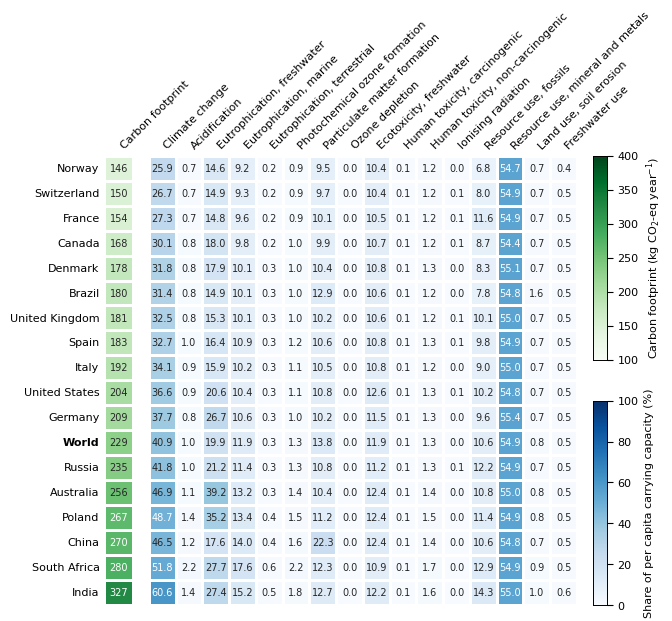

In [63]:
user = 'Medium technology user'
user_pb = CARRYING_CAPACITY_medium
fig_name = 'fig_2.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc, user_pb, fig_name)

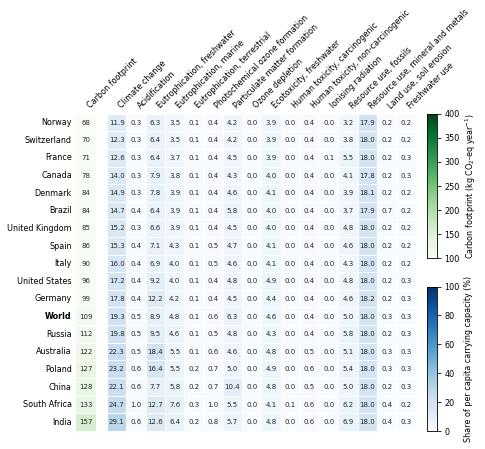

In [13]:
user = 'Low technology user'
user_pb = CARRYING_CAPACITY_low
fig_name = 'SI_Results_low_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

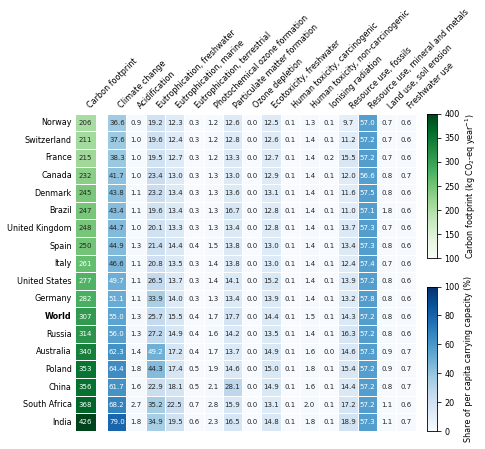

In [14]:
user = 'High technology user'
user_pb = CARRYING_CAPACITY_high
fig_name = 'SI_Results_high_technology_user.jpg'
fig, axs = pb_share_fig(user, carbon_footprint_loc_df, user_pb, fig_name)

### Climate impacts under different carbon budgets

In [12]:
# Import carbon budgets for different targets and probabilities
CARBON_BUDGETS = pd.read_excel(Path(r"..\data\Sensitivity-Analysis-Carbon-Budgets.xlsx"),
                               index_col=0)
CARBON_BUDGETS

,17%,33%,50%,67%,83%
Target,,,,,
1.5 °C,1126.268612,813.416220,625.704785,500.563828,375.422871
1.7 °C,1814.543875,1313.980048,1063.698134,875.986698,688.275263
2.0 °C,2878.242009,2127.396267,1689.402918,1439.121004,1126.268612


In [13]:
CARBON_BUDGETS_current = dict()
for target in CARBON_BUDGETS.index:
    CARBON_BUDGETS_current[target] = {}
    for prob in CARBON_BUDGETS.columns:
        CARBON_BUDGETS_current[target][prob] = {}
        for loc in LCIA_users['Medium technology user']:
            CARBON_BUDGETS_current[target][prob][loc] = LCIA_users['Medium technology user'][loc]['Climate change'] * 100 / CARBON_BUDGETS.loc[target, prob]

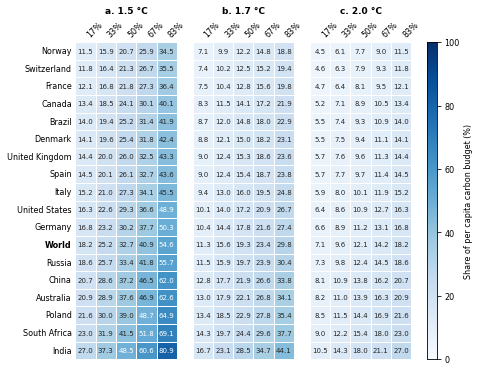

In [27]:
T_targets = list(CARBON_BUDGETS.index)

fig, axs = plt.subplot_mosaic([T_targets + ['cbar']],
                              figsize=(fig_length[2]*0.9, fig_height*0.6), 
                               gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})

axs[T_targets[0]].set_title('a. ' + T_targets[0], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[1]].set_title('b. ' + T_targets[1], fontweight='bold', loc='center', fontsize=fontsize_title)
axs[T_targets[2]].set_title('c. ' + T_targets[2], fontweight='bold', loc='center', fontsize=fontsize_title)

for tt in T_targets:
    data_to_plot = pd.DataFrame(CARBON_BUDGETS_current[tt]).sort_values('17%')
    sns.heatmap(ax=axs[tt], data=data_to_plot, cmap="Blues", vmin=0, vmax=100, 
                annot=True, fmt='.1f', annot_kws={"size": 7}, xticklabels=True, yticklabels=True, linewidths=0.8, linecolor='white', 
                cbar=True, cbar_ax=axs['cbar'])
    axs[tt].xaxis.tick_top()
    axs[tt].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[tt].set_xticklabels(list(data_to_plot.columns), rotation = 45, ha="left", fontsize=fontsize_axs)

for tt in T_targets[1:]:
    axs[tt].set_yticklabels('')
for lab, annot in zip(axs[T_targets[0]].get_yticklabels(), axs[T_targets[0]].texts):
    text = lab.get_text()
    if text in ['Europe', 'World']:
        lab.set_weight('bold')
        
for spine in axs['cbar'].spines.values():
    spine.set(visible=True, lw=spineline_width, edgecolor="black")
axs['cbar'].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
axs['cbar'].set_ylabel('Share of per capita carbon budget (%)', fontsize=fontsize_label)

fig.subplots_adjust(wspace=0.2)
plt.savefig(Path(str(r"..\reports\submission") + '/SI_carbon_budget_sensitivity.jpg'), dpi=600, bbox_inches='tight')

## Uncertainty analysis - Monte Carlo simulation
Only for GLO location

In [282]:
GLO_user_ds = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]
GLO_user_ds

'digital content consumption, medium technology user' (year, GLO, None)

Impact values

In [9]:
iterations = 1000
methods_for_mc = {k:v for (k,v) in LCIA_METHODS.items() if k != 'Carbon footprint'}
MonteCarlo_results_GLO = multi_lcia_MonteCarlo(GLO_user_ds,
                                               iterations, 
                                               methods_for_mc)

In [10]:
# Statistical analysis of impact values
MonteCarlo_stats_GLO = pd.DataFrame(MonteCarlo_results_GLO).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
MonteCarlo_stats_GLO.loc['CV'] = MonteCarlo_stats_GLO.loc['std'] * 100 / MonteCarlo_stats_GLO.loc['mean']
MonteCarlo_stats_GLO.T.drop('count', axis=1)

,mean,std,min,5%,25%,50%,75%,95%,max,CV
Climate change,2.440286e+02,2.254606e+01,1.858394e+02,2.096406e+02,2.280686e+02,2.429731e+02,2.585753e+02,2.818162e+02,346.656878,9.239104
Acidification,1.693146e+00,1.579111e-01,1.300669e+00,1.450357e+00,1.581188e+00,1.678729e+00,1.792719e+00,1.979318e+00,2.274653,9.326492
"Eutrophication, freshwater",2.343079e-01,9.202134e-02,9.663168e-02,1.302566e-01,1.687126e-01,2.119467e-01,2.735372e-01,4.076022e-01,0.851329,39.273683
"Eutrophication, marine",4.384150e-01,4.422059e-02,3.251528e-01,3.717149e-01,4.076082e-01,4.346225e-01,4.639924e-01,5.176820e-01,0.593226,10.086470
"Eutrophication, terrestrial",3.237059e+00,3.370282e-01,2.383419e+00,2.742019e+00,3.000652e+00,3.199195e+00,3.457822e+00,3.859018e+00,4.521077,10.411554
Photochemical ozone formation,8.942220e-01,9.059888e-02,6.715954e-01,7.633333e-01,8.288341e-01,8.848366e-01,9.528297e-01,1.062062e+00,1.233978,10.131587
Particulate matter formation,1.615966e-05,8.987502e-06,7.382940e-06,9.025910e-06,1.108940e-05,1.381943e-05,1.814828e-05,3.134871e-05,0.000104,55.616896
Ozone depletion,2.039158e-05,5.556556e-06,9.643105e-06,1.376101e-05,1.683849e-05,1.933103e-05,2.291376e-05,3.002237e-05,0.000058,27.249264
"Ecotoxicity, freshwater",2.777908e+03,4.722407e+02,1.565265e+03,2.116756e+03,2.434050e+03,2.717746e+03,3.042721e+03,3.627268e+03,4710.508565,16.999869
"Human toxicity, carcinogenic",2.473734e-07,3.682335e-07,-9.693081e-07,-2.386920e-07,6.355766e-08,2.348740e-07,4.141970e-07,7.409874e-07,0.000007,148.857312


Share of per capita carrying capacity

In [11]:
MonteCarlo_PB_GLO = dict()
for method in methods_for_mc:
    MonteCarlo_PB_GLO[method] = [i * 100 / carrying_capacity_per_capita['carrying_capacity_2020'].to_dict()[method] for i in MonteCarlo_results_GLO[method]]

In [17]:
# Statistical analysis of share of per capita carrying capacity
MonteCarlo_stats_PB_GLO = pd.DataFrame(MonteCarlo_PB_GLO).describe(percentiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975])
MonteCarlo_stats_PB_GLO.loc['CV'] = MonteCarlo_stats_PB_GLO.loc['std'] * 100 / MonteCarlo_stats_PB_GLO.loc['mean']
MonteCarlo_stats_PB_GLO.loc['deterministic'] = CARRYING_CAPACITY_results['Medium technology user']['World']
MonteCarlo_stats_PB_GLO
MonteCarlo_stats_PB_GLO.T.drop('count', axis=1).round(2).astype(str) + '%'

,mean,std,min,2.5%,5%,25%,50%,75%,95%,97.5%,max,CV,deterministic
Climate change,48.75%,4.5%,37.13%,40.86%,41.88%,45.56%,48.54%,51.66%,56.3%,58.31%,69.25%,9.24%,40.92%
Acidification,1.32%,0.12%,1.01%,1.1%,1.13%,1.23%,1.31%,1.4%,1.54%,1.59%,1.77%,9.33%,1.04%
"Eutrophication, freshwater",31.44%,12.35%,12.97%,16.14%,17.48%,22.64%,28.44%,36.7%,54.69%,63.3%,114.22%,39.27%,19.9%
"Eutrophication, marine",14.67%,1.48%,10.88%,12.11%,12.44%,13.64%,14.54%,15.52%,17.32%,17.96%,19.85%,10.09%,11.89%
"Eutrophication, terrestrial",0.41%,0.04%,0.3%,0.34%,0.35%,0.38%,0.41%,0.44%,0.49%,0.51%,0.57%,10.41%,0.32%
Photochemical ozone formation,1.71%,0.17%,1.29%,1.42%,1.46%,1.59%,1.7%,1.83%,2.04%,2.1%,2.37%,10.13%,1.3%
Particulate matter formation,21.61%,12.02%,9.87%,11.43%,12.07%,14.83%,18.48%,24.27%,41.93%,54.26%,139.08%,55.62%,13.77%
Ozone depletion,0.04%,0.01%,0.02%,0.03%,0.03%,0.04%,0.04%,0.05%,0.07%,0.08%,0.13%,27.25%,0.03%
"Ecotoxicity, freshwater",16.7%,2.84%,9.41%,12.25%,12.73%,14.64%,16.34%,18.3%,21.81%,23.24%,28.32%,17.0%,11.93%
"Human toxicity, carcinogenic",0.18%,0.26%,-0.7%,-0.24%,-0.17%,0.05%,0.17%,0.3%,0.53%,0.66%,4.82%,148.86%,0.1%


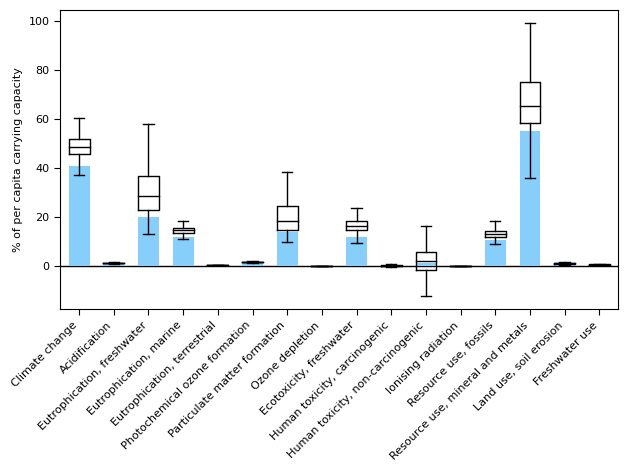

In [20]:
width=0.6

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.4))

box_color = 'black'
boxprops = dict(linestyle='-', linewidth=1, color=box_color)
flierprops = dict(marker='o', markerfacecolor=box_color, markersize=12, linestyle='none')
medianprops = dict(linestyle='-', linewidth=1, color=box_color)
meanpointprops = dict(marker='D', markeredgecolor='grey', markerfacecolor=box_color)
meanlineprops = dict(linestyle='--', linewidth=2.5, color=box_color)
whiskerprops = dict(color=box_color)
capprops = dict(color=box_color)

# Monte Carlo simulation outputs
axs.boxplot(MonteCarlo_PB_GLO.values(), positions=range(len(MonteCarlo_PB_GLO.keys())),
            showfliers=False, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, 
            medianprops=medianprops)

# Deterministic results:
MonteCarlo_stats_PB_GLO.T[['deterministic']].plot.bar(ax=axs, color='lightskyblue', width=width, legend=False)

axs.set_xticklabels(list(MonteCarlo_PB_GLO.keys()), rotation = 45, ha="right", fontsize=fontsize_axs)
axs.set_ylabel('% of per capita carrying capacity', fontsize=fontsize_label)

axs.tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=4, labelsize=fontsize_axs)

axs.axhline(0, color='black', linestyle='-', linewidth=1, zorder=0)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_MonteCarlo_results.jpg'), dpi=600, bbox_inches='tight')

## Contribution analysis by system component

In [14]:
locations_CA = ['NO', 'GLO', 'IN']

In [15]:
CA_system_medium_CH_GLO_IN = {}
for loc in locations_CA:
    activity = [ds for ds in bw.Database(DBS['Digital content']) if 'medium technology user' in ds['name'] and ds['location'] == loc][0]
    system_contributions = internet_system_contributions(activity,
                                                         LCIA_METHODS,
                                                         activity_amount=1)
    CA_system_medium_CH_GLO_IN[loc] = system_contributions

In [16]:
LOC_ANALYSIS = 'GLO'
CA_system_absolute = pd.DataFrame(CA_system_medium_CH_GLO_IN[LOC_ANALYSIS])
CA_system_relative = (CA_system_absolute.T * 100 / CA_system_absolute.T.sum()).T

# Save results to csv
#CA_system_relative.to_csv(DATA_DIR / "results" / "fig3_contribution_analysis_GLO.csv")

CA_system_relative

,End-user devices | operation,End-user devices | embodied,CPE | operation,CPE | embodied,Access network | operation,Core network | operation,Data centres | operation,Data centres | embodied
Carbon footprint,21.929346,32.325353,7.116611,0.218694,2.846644,10.757096,24.353631,0.452626
Climate change,22.116073,31.597314,7.177208,0.216974,2.870883,10.881207,24.693437,0.446903
Acidification,19.365273,40.927350,6.284506,0.392553,2.513802,9.240946,20.634273,0.641297
"Eutrophication, freshwater",16.267944,44.871320,5.279347,0.532320,2.111739,8.511357,21.641126,0.784846
"Eutrophication, marine",13.642113,46.521885,4.427200,0.210753,1.770880,6.498609,26.534825,0.393735
"Eutrophication, terrestrial",19.401307,41.107317,6.296200,0.331426,2.518480,9.141363,20.607110,0.596798
Photochemical ozone formation,19.252577,41.905279,6.247933,0.328408,2.499173,9.108976,20.006634,0.651021
Particulate matter formation,19.019967,41.897709,6.172446,0.288814,2.468978,8.918096,20.616622,0.617368
Ozone depletion,13.142269,56.389096,4.264989,0.332312,1.705995,6.808534,16.722777,0.634028
"Ecotoxicity, freshwater",8.220718,64.500581,2.667825,0.755058,1.067130,4.359574,17.329843,1.099273


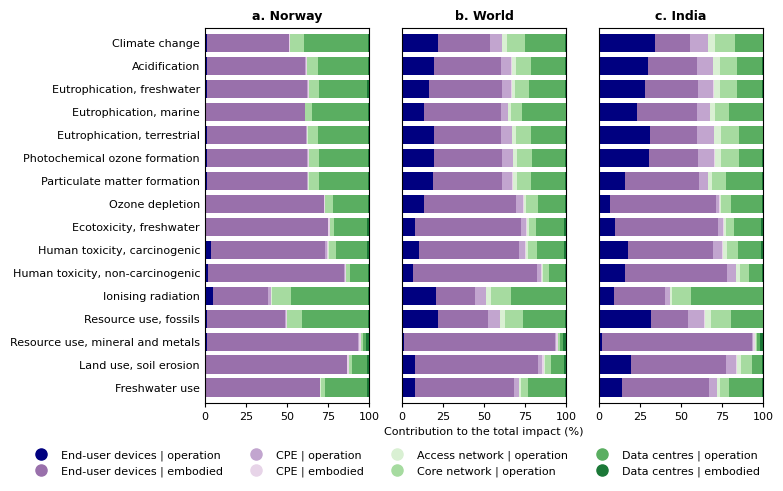

In [117]:
width=0.8

fig, axs = plt.subplots(1, 3, figsize=(fig_length[2], fig_height*0.5), sharey=True)

count_ax = 0
for loc in locations_CA:
    ds_plot = pd.DataFrame(CA_system_medium_CH_GLO_IN[loc])
    ds_plot = (ds_plot.T * 100 / ds_plot.T.sum()).T
    
    ds_plot.iloc[1:].plot.barh(ax=axs[count_ax], stacked=True, width=width, fontsize=fontsize_axs, 
                      lw=spineline_width, color=system_color, legend=False, zorder=2)
    axs[count_ax].invert_yaxis()
    
    axs[count_ax].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[count_ax].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
    
    axs[count_ax].set_xlim(0, 100)
    
    count_ax += 1

axs[1].set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

axs[0].set_title('a. Norway', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[1].set_title('b. World', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[2].set_title('c. India', fontweight='bold', loc='center', fontsize=fontsize_title)

patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
              bbox_to_anchor=(2.24,-0.1), ncol=4, frameon=False, edgecolor='black',  
              facecolor='White', fontsize=fontsize_legend)

#plt.savefig(Path(str(r"..\reports\submission") + '/fig_3.jpg'), dpi=600, bbox_inches='tight')

### Contribution analysis of embodied and operational impacts of end-user devices

Only for the GLO average user

In [227]:
user_devices_embodied_lcia = user_devices_embodied_impacts(GLO_user_ds, LCIA_METHODS, activity_amount=1)
user_devices_operational_lcia = user_devices_operational_impacts(GLO_user_ds, LCIA_METHODS, activity_amount=1)

In [228]:
user_devices_embodied_lcia_df = pd.DataFrame(user_devices_embodied_lcia)
user_devices_operational_lcia_df = pd.DataFrame(user_devices_operational_lcia)

In [232]:
user_devices_embodied_total_share = (user_devices_embodied_lcia_df.T * 100 / user_devices_embodied_lcia_df.T.sum()).T.iloc[1:]
user_devices_embodied_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,14.492975,15.706093,20.987581,38.242493,10.570857
Acidification,10.821199,11.788920,19.295479,38.683409,19.410993
"Eutrophication, freshwater",10.117620,10.873174,21.414072,39.084005,18.511129
"Eutrophication, marine",8.681580,9.815791,16.529771,56.805243,8.167616
"Eutrophication, terrestrial",10.538248,11.522233,19.721586,43.308853,14.909080
Photochemical ozone formation,11.137123,11.832790,18.628028,40.027242,18.374816
Particulate matter formation,10.100420,11.146575,22.867092,38.337977,17.547936
Ozone depletion,23.114232,25.441983,16.616746,27.549294,7.277746
"Ecotoxicity, freshwater",6.237863,6.661858,20.607877,46.053259,20.439143
"Human toxicity, carcinogenic",10.525869,11.399248,16.721007,40.168250,21.185625


In [231]:
user_devices_operational_total_share = (user_devices_operational_lcia_df.T * 100 / user_devices_operational_lcia_df.T.sum()).T.iloc[1:]
user_devices_operational_total_share

,Smartphone,Tablet,Laptop,Desktop computer,Television
Climate change,3.658307,2.873907,18.431338,66.248666,8.787783
Acidification,3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, marine",3.658307,2.873907,18.431338,66.248666,8.787783
"Eutrophication, terrestrial",3.658307,2.873907,18.431338,66.248666,8.787783
Photochemical ozone formation,3.658307,2.873907,18.431338,66.248666,8.787783
Particulate matter formation,3.658307,2.873907,18.431338,66.248666,8.787783
Ozone depletion,3.658307,2.873907,18.431338,66.248666,8.787783
"Ecotoxicity, freshwater",3.658307,2.873907,18.431338,66.248666,8.787783
"Human toxicity, carcinogenic",3.658307,2.873907,18.431338,66.248666,8.787783


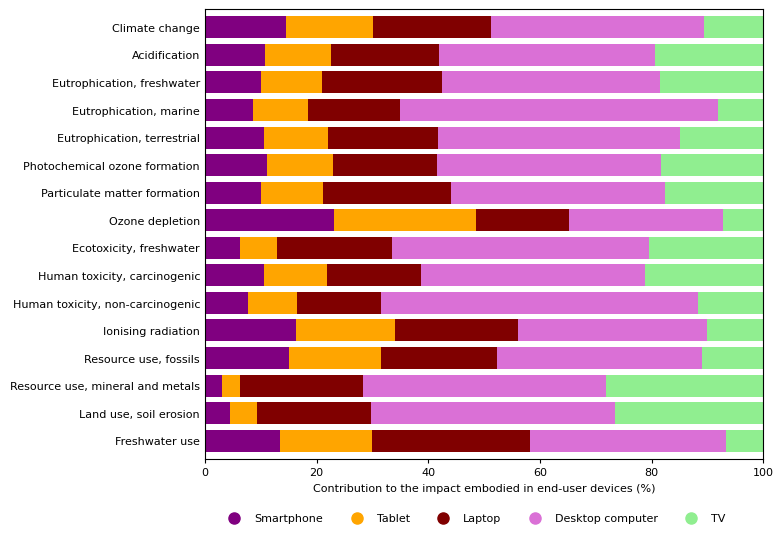

In [237]:
width=0.8
content_color = ['purple', 'orange', 'maroon', 'orchid', 'lightgreen']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.6))
    
user_devices_embodied_total_share.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)


axs.set_xlabel('Contribution to the impact embodied in end-user devices (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=END_USER_DEVICES[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=END_USER_DEVICES[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=END_USER_DEVICES[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=END_USER_DEVICES[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=END_USER_DEVICES[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
              bbox_to_anchor=(0.95,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_emboided_impacts_devices.jpg'), dpi=600, bbox_inches='tight')

### Contribution analysis by digital content

Only for the GLO user

In [238]:
CA_content_medium_GLO = digital_content_constributions(GLO_user_ds, LCIA_METHODS, DIGITAL_CONTENT, activity_amount=1)

In [239]:
CA_content_absolute = pd.DataFrame(CA_content_medium_GLO)
CA_content_relative = (CA_content_absolute.T * 100 / CA_content_absolute.T.sum()).T.iloc[1:]
CA_content_relative

,Web surfing,Social media,Video streaming,Music streaming,Video conferencing
Climate change,14.797137,15.063834,47.564333,11.071217,11.503479
Acidification,14.824921,14.187618,48.100598,11.165036,11.721826
"Eutrophication, freshwater",14.875703,13.955135,48.321121,11.044556,11.803486
"Eutrophication, marine",14.796813,14.189216,46.284371,11.583542,13.146058
"Eutrophication, terrestrial",15.182337,14.359091,46.702054,11.515447,12.241071
Photochemical ozone formation,14.971371,14.268029,47.551456,11.349006,11.860138
Particulate matter formation,15.216210,14.107106,47.402718,11.274518,11.999449
Ozone depletion,17.838904,16.964610,41.678966,13.388961,10.128559
"Ecotoxicity, freshwater",15.321806,12.471179,47.448574,11.560420,13.198021
"Human toxicity, carcinogenic",15.292289,13.506438,47.686013,11.688885,11.826375


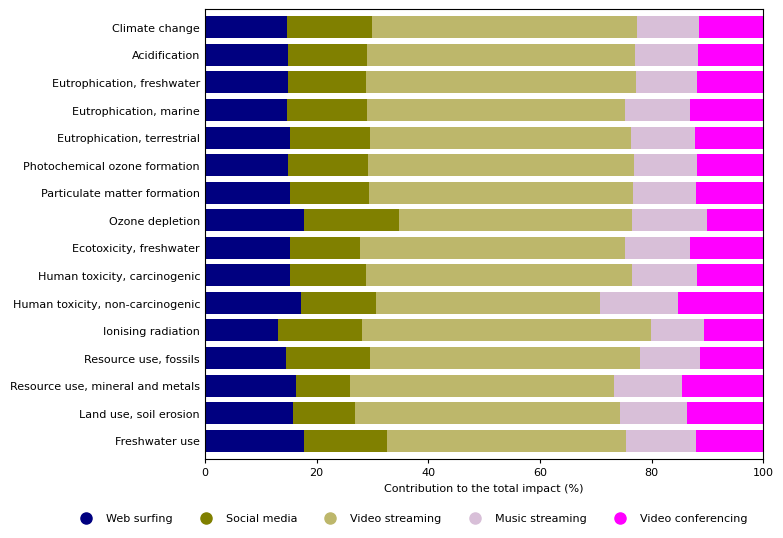

In [240]:
width=0.8
content_color = ['navy', 'olive', 'darkkhaki', 'thistle', 'fuchsia']

fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.6))
    
CA_content_relative.plot.barh(ax=axs, stacked=True, width=width, fontsize=fontsize_axs, color=content_color, legend=False, zorder=2)
axs.invert_yaxis()
    
axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
axs.set_xlim(0, 100)

axs.set_xlabel('Contribution to the total impact (%)', fontsize=fontsize_label)

patch_1 = Line2D([0], [0], color=content_color[0], label=DIGITAL_CONTENT[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=content_color[1], label=DIGITAL_CONTENT[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=content_color[2], label=DIGITAL_CONTENT[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=content_color[3], label=DIGITAL_CONTENT[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=content_color[4], label=DIGITAL_CONTENT[4], ls='None', marker='o', ms=8)

axs.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], 
               bbox_to_anchor=(0.99,-0.1), ncol=5, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_impacts_by_digital_content.jpg'), dpi=600, bbox_inches='tight')

## Impacts considering data centres powered by wind or solar PV electricity

Only for the GLO user

In [24]:
LCIA_current_wind_data_centres = lcia_per_user_and_loc(['Medium technology user'],
                                                        {'GLO': 'World'},
                                                        DBS['Digital content Wind data centres'],
                                                        LCIA_METHODS)

LCIA_current_solar_data_centres = lcia_per_user_and_loc(['Medium technology user'],
                                                        {'GLO': 'World'},
                                                        DBS['Digital content Solar data centres'],
                                                        LCIA_METHODS)

In [25]:
CARRYING_CAPACITY_current_wind_data_centres = impacts_vs_carrying_capacity(['Medium technology user'],
                                                                            {'GLO': 'World'},
                                                                            LCIA_current_wind_data_centres,
                                                                            carrying_capacity_per_capita['carrying_capacity_2020'])

CARRYING_CAPACITY_current_solar_data_centres = impacts_vs_carrying_capacity(['Medium technology user'],
                                                                            {'GLO': 'World'},
                                                                            LCIA_current_solar_data_centres,
                                                                            carrying_capacity_per_capita['carrying_capacity_2020'])

In [26]:
CARRYING_CAPACITY_data_centres_elec = {}
CARRYING_CAPACITY_data_centres_elec['Wind'] = {}
CARRYING_CAPACITY_data_centres_elec['Solar PV'] = {}

for impact in LCIA_METHODS.keys():
    if impact == 'Carbon footprint':
        pass
    else:
        CARRYING_CAPACITY_data_centres_elec['Wind'][impact] = {}
        CARRYING_CAPACITY_data_centres_elec['Solar PV'][impact] = {}

        for share_ren in range(0,120,20):
            impact_wind = CARRYING_CAPACITY_current_wind_data_centres['Medium technology user']['World'][impact] * share_ren /100
            impact_solar = CARRYING_CAPACITY_current_solar_data_centres['Medium technology user']['World'][impact] * share_ren /100

            impact_regional_mix = CARRYING_CAPACITY_current['Medium technology user']['World'][impact] * (100 - share_ren) /100

            CARRYING_CAPACITY_data_centres_elec['Wind'][impact][share_ren] = impact_wind + impact_regional_mix
            CARRYING_CAPACITY_data_centres_elec['Solar PV'][impact][share_ren] = impact_solar + impact_regional_mix

In [27]:
pd.DataFrame(CARRYING_CAPACITY_data_centres_elec['Wind']).rename(index={0: '0% renewable electricity',
                                                                        20: '20% renewable electricity',
                                                                        40: '40% renewable electricity',
                                                                        60: '60% renewable electricity',
                                                                        80: '80% renewable electricity',
                                                                        100: '100% renewable electricity'})

,Climate change,Acidification,"Eutrophication, freshwater","Eutrophication, marine","Eutrophication, terrestrial",Photochemical ozone formation,Particulate matter formation,Ozone depletion,"Ecotoxicity, freshwater","Human toxicity, carcinogenic","Human toxicity, non-carcinogenic",Ionising radiation,"Resource use, fossils","Resource use, mineral and metals","Land use, soil erosion",Freshwater use
0% renewable electricity,40.921658,1.039055,19.898808,11.885847,0.317674,1.303036,13.769165,0.028201,11.925341,0.099821,1.312854,0.046859,10.551544,54.883255,0.751350,0.504538
20% renewable electricity,39.004234,0.999426,19.118033,11.568507,0.305904,1.255276,13.289496,0.027348,11.688887,0.098240,1.295346,0.043794,10.023872,54.721400,0.741423,0.495157
40% renewable electricity,37.086810,0.959797,18.337258,11.251166,0.294133,1.207515,12.809827,0.026495,11.452433,0.096658,1.277838,0.040729,9.496200,54.559545,0.731496,0.485776
60% renewable electricity,35.169385,0.920168,17.556484,10.933826,0.282362,1.159754,12.330158,0.025641,11.215979,0.095076,1.260330,0.037664,8.968528,54.397690,0.721570,0.476396
80% renewable electricity,33.251961,0.880539,16.775709,10.616486,0.270591,1.111993,11.850489,0.024788,10.979525,0.093494,1.242822,0.034599,8.440856,54.235835,0.711643,0.467015
100% renewable electricity,31.334537,0.840910,15.994934,10.299145,0.258820,1.064233,11.370820,0.023935,10.743072,0.091912,1.225314,0.031534,7.913184,54.073979,0.701716,0.457634


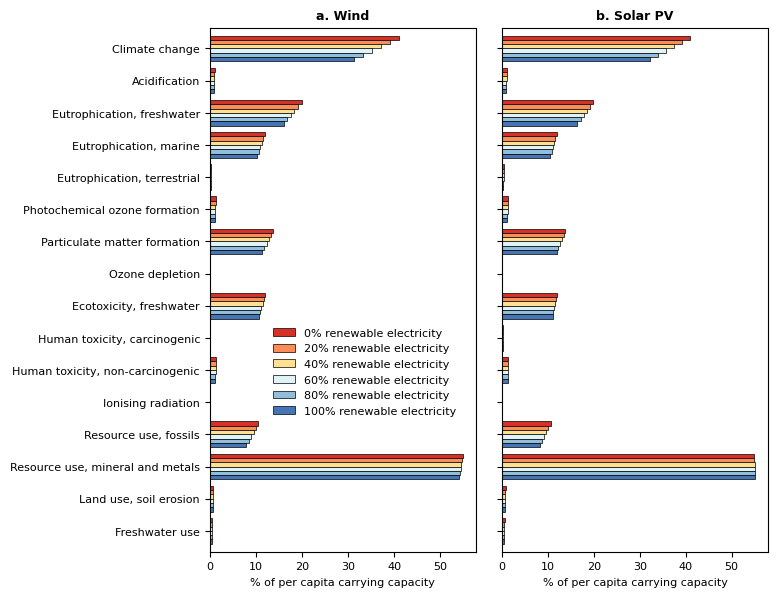

In [197]:
width=0.8
fig, axs = plt.subplots(1, 2, figsize=(fig_length[2], fig_height*0.7), sharey=True)
sc_colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
sc_rename = {0: '0% renewable electricity',
             20: '20% renewable electricity',
             40: '40% renewable electricity',
             60: '60% renewable electricity',
             80: '80% renewable electricity',
             100: '100% renewable electricity'}

axs[0].set_title('a. Wind', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[1].set_title('b. Solar PV', fontweight='bold', loc='center', fontsize=fontsize_title)

pd.DataFrame(CARRYING_CAPACITY_data_centres_elec['Wind']).rename(index=sc_rename).T.plot.barh(ax=axs[0], width=width, fontsize=fontsize_axs, 
                                                                      color=sc_colors, edgecolor='black', linewidth=0.5, legend=True, zorder=2)
pd.DataFrame(CARRYING_CAPACITY_data_centres_elec['Solar PV']).T.plot.barh(ax=axs[1], width=width, fontsize=fontsize_axs, 
                                                                          color=sc_colors, edgecolor='black', linewidth=0.5, legend=False, zorder=2)

for i in range(2):
    axs[i].set_xlabel('% of per capita carrying capacity', fontsize=fontsize_label)

axs[0].invert_yaxis()

axs[0].legend(bbox_to_anchor=(0.2,0.24), ncol=1, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

fig.subplots_adjust(wspace=0.1)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_impacts_data_centres_electricity.jpg'), dpi=600, bbox_inches='tight')

### Breakdown of impacts for scenario with data centres powered by renewable electricity

In [28]:
activity_wind_data_centres = [ds for ds in bw.Database(DBS['Digital content Wind data centres']) 
                              if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]

system_contributions_wind_data_centres = internet_system_contributions(activity_wind_data_centres,
                                                                       LCIA_METHODS,
                                                                       activity_amount=1)

In [29]:
activity_solar_data_centres = [ds for ds in bw.Database(DBS['Digital content Solar data centres']) 
                              if 'medium technology user' in ds['name'] and ds['location'] == 'GLO'][0]

system_contributions_solar_data_centres = internet_system_contributions(activity_solar_data_centres,
                                                                       LCIA_METHODS,
                                                                       activity_amount=1)

In [55]:
CA_system_absolute_wind_data_centres = pd.DataFrame(system_contributions_wind_data_centres)[['Data centres | operation', 'Data centres | embodied']]
CA_system_relative_wind_data_centres = (CA_system_absolute_wind_data_centres.T * 100 / CA_system_absolute_wind_data_centres.T.sum()).T
CA_system_relative_wind_data_centres

,Data centres | operation,Data centres | embodied
Carbon footprint,73.930002,26.069998
Climate change,73.901214,26.098786
Acidification,70.927771,29.072229
"Eutrophication, freshwater",72.043042,27.956958
"Eutrophication, marine",97.100422,2.899578
"Eutrophication, terrestrial",77.709007,22.290993
Photochemical ozone formation,72.070567,27.929433
Particulate matter formation,83.820581,16.179419
Ozone depletion,71.561291,28.438709
"Ecotoxicity, freshwater",87.090454,12.909546


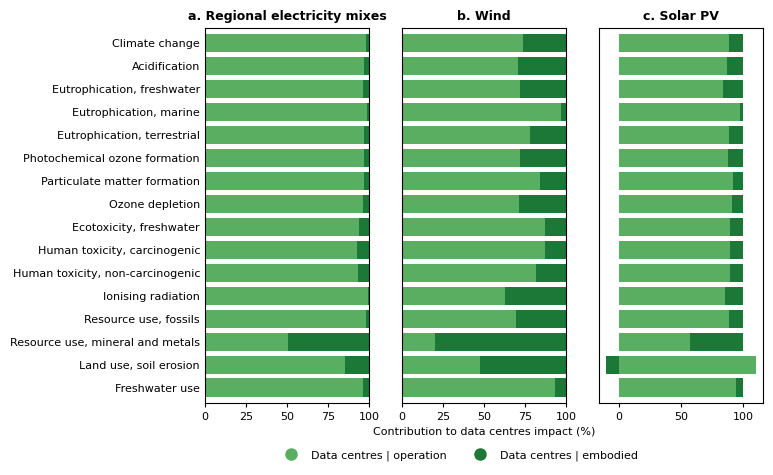

In [53]:
width=0.8
data_centre_color = ['#5aae61', '#1b7837']

fig, axs = plt.subplots(1, 3, figsize=(fig_length[2], fig_height*0.5), sharey=True)

data_centre_contributions = [pd.DataFrame(CA_system_medium_CH_GLO_IN['GLO'])[['Data centres | operation', 'Data centres | embodied']],
                             pd.DataFrame(system_contributions_wind_data_centres)[['Data centres | operation', 'Data centres | embodied']],
                             pd.DataFrame(system_contributions_solar_data_centres)[['Data centres | operation', 'Data centres | embodied']]]

for i in range(3):
    data_relative = (data_centre_contributions[i].T * 100 / data_centre_contributions[i].T.sum()).T
    data_relative.iloc[1:].plot.barh(ax=axs[i], stacked=True, width=width, fontsize=fontsize_axs, 
                                                        lw=spineline_width, color=data_centre_color, legend=False, zorder=2)
    
    axs[i].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[i].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)

    if i < 2:
        axs[i].set_xlim(0, 100)

axs[0].invert_yaxis()

axs[1].set_xlabel('Contribution to data centres impact (%)', fontsize=fontsize_label)

axs[0].set_title('a. Regional electricity mixes', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[1].set_title('b. Wind', fontweight='bold', loc='center', fontsize=fontsize_title)
axs[2].set_title('c. Solar PV', fontweight='bold', loc='center', fontsize=fontsize_title)

patch_7 = Line2D([0], [0], color=data_centre_color[0], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=data_centre_color[1], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1].legend(handles=[patch_7, patch_8], 
              bbox_to_anchor=(1.5,-0.1), ncol=4, frameon=False, edgecolor='black',  
              facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports\submission") + '/SI_breadown_impacts_data_centres_electricity.jpg'), dpi=600, bbox_inches='tight')

# Prospective analysis

Only for average consumption patterns

## Only background electricity generation prospective

In [22]:
DBS_PROSPECTIVE = {db: DBS[db] for db in DBS
                   if ('Ecoinvent' not in db) 
                   and (('Base' in db) or ('RCP26' in db) or ('RCP19' in db))
                   and "2030" in db}

DBS_PROSPECTIVE

{'Digital content Base 2030': 'internet-environmental-footprint, IMAGE SSP2-Base, 2030',
 'Digital content RCP26 2030': 'internet-environmental-footprint, IMAGE SSP2-RCP26, 2030',
 'Digital content RCP19 2030': 'internet-environmental-footprint, IMAGE SSP2-RCP19, 2030'}

In [23]:
# Calculate GLO average impacts by scenario and year
YEARS = 2030 #[2030, 2040, 2050]
LCIA_YEAR_SCENARIO = {}

for scenario in ['Base', 'RCP26', 'RCP19']:
    LCIA_YEAR_SCENARIO[scenario] = {}
    for year in YEARS:
        DB_ASSESSED = [db for db in DBS_PROSPECTIVE if scenario in db and str(year) in db][0]
        impacts = lcia_per_user_and_loc(['Medium technology user'],
                                        {'GLO': 'World'},
                                        DBS[DB_ASSESSED],
                                        LCIA_METHODS)
        LCIA_YEAR_SCENARIO[scenario][year] = impacts['Medium technology user']['World']

In [24]:
# Calculate GLO average share of carrying capacity by scenario and year
CARRYING_CAPACITY_YEAR_SCENARIO = {}
for scenario in LCIA_YEAR_SCENARIO:
    CARRYING_CAPACITY_YEAR_SCENARIO[scenario] = {}
    for year in LCIA_YEAR_SCENARIO[scenario]:
        if year == 2030:
            carrying_capacity_year = carrying_capacity_per_capita['carrying_capacity_2030']
        elif year == 2040:
            carrying_capacity_year = carrying_capacity_per_capita['carrying_capacity_2040']
        elif year == 2050:
            carrying_capacity_year = carrying_capacity_per_capita['carrying_capacity_2050']
        CARRYING_CAPACITY_YEAR_SCENARIO[scenario][year] = {}

        for impact in LCIA_YEAR_SCENARIO[scenario][year]:
            if impact == 'Carbon footprint':
                pass
            else:
                CARRYING_CAPACITY_YEAR_SCENARIO[scenario][year][impact] = LCIA_YEAR_SCENARIO[scenario][year][impact] * 100 / carrying_capacity_year[impact]

In [25]:
# Add curent impacts (2020) and change order of nested dictionary:
for scenario in ['Base', 'RCP26', 'RCP19']:
    CARRYING_CAPACITY_YEAR_SCENARIO[scenario][2020] = {}
    for impact in CARRYING_CAPACITY_medium['World'].index:
        CARRYING_CAPACITY_YEAR_SCENARIO[scenario][2020][impact] = CARRYING_CAPACITY_medium['World'].loc[impact]

CARRYING_CAPACITY_YEAR_SCENARIO_new = {}
for key1, val1 in CARRYING_CAPACITY_YEAR_SCENARIO.items():
    for key2, val2 in val1.items():
        for key3, val3 in val2.items():
            if key3 not in CARRYING_CAPACITY_YEAR_SCENARIO_new:
                CARRYING_CAPACITY_YEAR_SCENARIO_new[key3] = {}
            if key1 not in CARRYING_CAPACITY_YEAR_SCENARIO_new[key3]:
                CARRYING_CAPACITY_YEAR_SCENARIO_new[key3][key1] = {}
            CARRYING_CAPACITY_YEAR_SCENARIO_new[key3][key1][key2] = val3

In [78]:
pd.DataFrame(CARRYING_CAPACITY_YEAR_SCENARIO_new['Resource use, mineral and metals'])

,Base,RCP26,RCP19
2030,60.300696,60.311916,60.439989
2020,54.883255,54.883255,54.883255


### Prospective contribution analysis

In [124]:
categories_prospective = ['Climate change',
                          'Eutrophication, freshwater',
                          'Eutrophication, marine',
                          'Particulate matter formation',
                          'Ecotoxicity, freshwater',
                          'Resource use, mineral and metals']
LCIA_METHODS_PROSPECTIVE = {impact: LCIA_METHODS[impact] for impact in categories_prospective}

In [30]:
CA_system_medium_prospective = {}

for db in DBS_PROSPECTIVE:
    CA_system_medium_prospective[db] = {}
    activity = [ds for ds in bw.Database(DBS_PROSPECTIVE[db]) if 'medium technology user' in ds['name'] 
                                             and ds['location'] == 'GLO'][0]
    CA_system_medium_prospective[db] = internet_system_contributions(activity,
                                                                     LCIA_METHODS_PROSPECTIVE,
                                                                     activity_amount=1)

In [33]:
CA_system_medium_timeserie = {}
for impact in LCIA_METHODS_PROSPECTIVE:
    CA_system_medium_timeserie[impact] = {}
    for system in INTERNET_COMPONENTS:
        CA_system_medium_timeserie[impact][system] = {}

        CA_system_medium_timeserie[impact][system]['Current'] = CA_system_medium_CH_GLO_IN['GLO'][system][impact]

        CA_system_medium_timeserie[impact][system]['2030 | 3.5 °C'] = CA_system_medium_prospective['Digital content Base 2030'][system][impact]

        CA_system_medium_timeserie[impact][system]['2030 | 2 °C'] = CA_system_medium_prospective['Digital content RCP26 2030'][system][impact]

        CA_system_medium_timeserie[impact][system]['2030 | 1.5 °C'] = CA_system_medium_prospective['Digital content RCP19 2030'][system][impact]

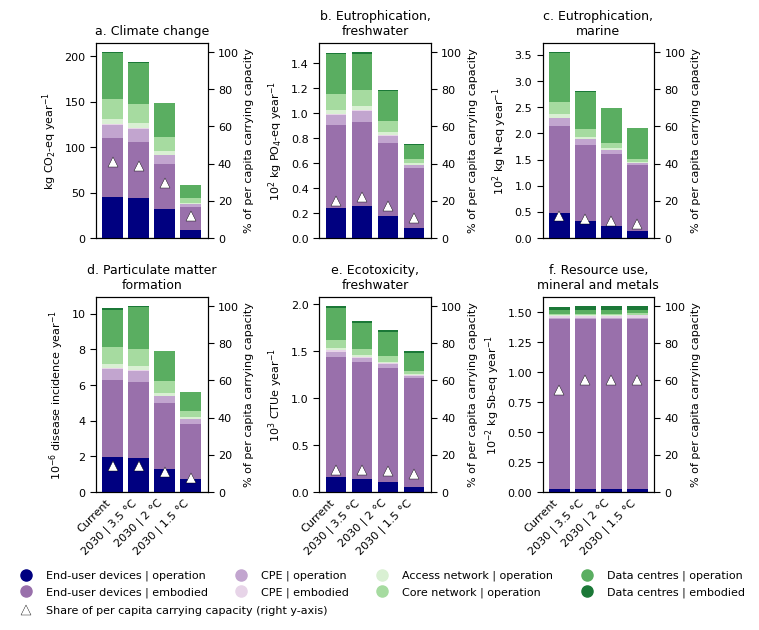

In [213]:
prospective_categories = list(LCIA_METHODS_PROSPECTIVE.keys())
categories_titles = ['a. Climate change',
                     'b. Eutrophication,\nfreshwater',
                     'c. Eutrophication,\nmarine',
                     'd. Particulate matter\nformation',
                     'e. Ecotoxicity,\nfreshwater',
                     'f. Resource use,\nmineral and metals']
categories_units = ['kg CO$_2$-eq year$^{-1}$',
                    '10$^{2}$ kg PO$_4$-eq year$^{-1}$',
                    '10$^{2}$ kg N-eq year$^{-1}$',
                    '10$^{-6}$ disease incidence year$^{-1}$',
                    '10$^{3}$ CTUe year$^{-1}$',
                    '10$^{-2}$ kg Sb-eq year$^{-1}$',]
multiply_values = [1,
                   10,
                   10,
                   1e6, 
                   1e-3,
                   1e2]
shares_lims = [[-5,50],
               [0,100],
                [0,100],
                [0,100],
                [0,100],
                [0,100],]

YEARS_PLOT = [2030] #[2030, 2050]

width=0.8

fig, axs = plt.subplots(2, 3, figsize=(fig_length[2], fig_height*0.6), sharex=True)

counter=0
for row in range(2):
    for col in range(3):
        axs[row,col].set_title(categories_titles[counter], loc='center', fontsize=fontsize_title)
        axs[row,col].set_ylabel(categories_units[counter], fontsize=fontsize_label) 

        data_to_plot = pd.DataFrame(CA_system_medium_timeserie[prospective_categories[counter]]) * multiply_values[counter]
        data_to_plot.plot.bar(stacked=True, ax=axs[row,col], width=width, color=system_color, zorder=3, legend=False)
        
        axs[row,col].axhline(y=0, ls='-', color='black', lw=0.8, zorder=2)
      #  axs[row,col].set_ylim(ymin=0)
        
        axs[row,col].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs[row,col].yaxis.offsetText.set_fontsize(fontsize_axs)

        axs[row,col].set_xticklabels(data_to_plot.index, rotation = 45, ha="right", fontsize=fontsize_axs)

        # Add share of carrying capacity
        axs1 = axs[row,col].twinx()
        marker_style = "^"
        marker_color = 'white'
        marker_size = 7
        axs1.plot(0, CARRYING_CAPACITY_YEAR_SCENARIO_new[prospective_categories[counter]]['Base'][2020], 
                  marker=marker_style, ms=marker_size, color=marker_color, mec='black', mew=0.3)
        count_pos = 1
        for sc in ['Base', 'RCP26', 'RCP19']:
            for year in YEARS_PLOT:
                axs1.plot(count_pos, CARRYING_CAPACITY_YEAR_SCENARIO_new[prospective_categories[counter]][sc][year], 
                          marker=marker_style, ms=marker_size, color=marker_color,  mec='black', mew=0.3)
                count_pos += 1
        axs1.set_ylim(shares_lims[counter][0], shares_lims[counter][1])
       # if counter == 0:
       #     axs1.set_ylim(-15,105)
       # else:
        axs1.set_ylim(0,105)
        axs1.tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
        axs1.set_ylabel('% of per capita carrying capacity', fontsize=fontsize_label) 
        
        counter += 1

# LEGEND
patch_1 = Line2D([0], [0], color=system_color[0], label=INTERNET_COMPONENTS[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=system_color[1], label=INTERNET_COMPONENTS[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=system_color[2], label=INTERNET_COMPONENTS[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=system_color[3], label=INTERNET_COMPONENTS[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=system_color[4], label=INTERNET_COMPONENTS[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=system_color[5], label=INTERNET_COMPONENTS[5], ls='None', marker='o', ms=8)
patch_7 = Line2D([0], [0], color=system_color[6], label=INTERNET_COMPONENTS[6], ls='None', marker='o', ms=8)
patch_8 = Line2D([0], [0], color=system_color[7], label=INTERNET_COMPONENTS[7], ls='None', marker='o', ms=8)

axs[1,1].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6, patch_7, patch_8], 
                bbox_to_anchor=(3.9,-0.35), ncol=4, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

pb_line = [Line2D([0], [0], color=marker_color, ms=marker_size, marker=marker_style,  mec='black', mew=0.3, ls='None')]
labels = ['Share of per capita carrying capacity (right y-axis)']
axs[1,0].legend(pb_line, labels, frameon=False, bbox_to_anchor=(2.16, -0.53), fontsize=fontsize_axs)

fig.subplots_adjust(wspace=1, hspace=0.3)
plt.savefig(Path(str(r"..\reports\submission") + '/fig_4.jpg'), dpi=600, bbox_inches='tight')

## Sensitivity analysis on lifetime extension with presamples

In order to avoid the decoding presample json file fails, you need to install the latest presample version, i.e. 0.2.8.

However, the package has not been updated on pypi. To have version 0.2.8, you must install from source:

*python -m pip install git+https://github.com/PascalLesage/presamples.git@master*

Further information here: https://github.com/PascalLesage/presamples/issues/72

In [86]:
sensitivity_analysis_data = Path(r"..\data\Sensitivity-Analysis-LCI-for-Presamples.xlsx")

dbs_presamples = [('Ecoinvent', 'Digital content'),
                  ('Ecoinvent Base 2030', 'Digital content Base 2030'),
                  ('Ecoinvent RCP26 2030', 'Digital content RCP26 2030'),
                  ('Ecoinvent RCP19 2030', 'Digital content RCP19 2030')]

In [89]:
SA_lcia_Default, SA_lcia_carrying_capacity_Default = calculate_impacts_with_presamples(dbs_presamples[0],
                                                                                       DBS,
                                                                                       LCIA_METHODS,
                                                                                       carrying_capacity_per_capita['carrying_capacity_2020'])

SA_lcia_Base, SA_lcia_carrying_capacity_Base = calculate_impacts_with_presamples(dbs_presamples[1],
                                                                                 DBS,
                                                                                 LCIA_METHODS,
                                                                                 carrying_capacity_per_capita['carrying_capacity_2030'])

SA_lcia_RCP26, SA_lcia_carrying_capacity_RCP26 = calculate_impacts_with_presamples(dbs_presamples[2],
                                                                                   DBS,
                                                                                   LCIA_METHODS,
                                                                                   carrying_capacity_per_capita['carrying_capacity_2030'])

SA_lcia_RCP19, SA_lcia_carrying_capacity_RCP19 = calculate_impacts_with_presamples(dbs_presamples[3],
                                                                                   DBS,
                                                                                   LCIA_METHODS,
                                                                                   carrying_capacity_per_capita['carrying_capacity_2030'])


 ps_id, filepath: 7eae644312cb4fd59f9f33c298c01984 C:\Users\istrateir\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\7eae644312cb4fd59f9f33c298c01984

 ps_id, filepath: 511a355bdc0843e0bad1a1fd1c7691f9 C:\Users\istrateir\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\511a355bdc0843e0bad1a1fd1c7691f9

 ps_id, filepath: 9c72e028434c488fb985f73e6f01c540 C:\Users\istrateir\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\9c72e028434c488fb985f73e6f01c540

 ps_id, filepath: a44e6700e25f494bbc531171f31970c1 C:\Users\istrateir\AppData\Local\pylca\Brightway3\iri.5753d2a2da40d04ad7f3cc7a024b6e90\presamples\a44e6700e25f494bbc531171f31970c1


In [57]:
#sensitivity_analysis_lcia_carrying_capacity_RCP19.to_csv(DATA_DIR / "results" / "fig5_2050_RCP19_with_energy_efficiency_and_lifetime.csv")

#sensitivity_analysis_lcia_carrying_capacity_Base.to_csv(DATA_DIR / "results" / "SI_fig7_2050_Base_with_energy_efficiency_and_lifetime.csv")
#sensitivity_analysis_lcia_carrying_capacity_RCP26.to_csv(DATA_DIR / "results" / "SI_fig8_2050_RCP26_with_energy_efficiency_and_lifetime.csv")

In [ ]:
def presamples_results_fig(sensitivity_analysis_lcia_carrying_capacity, CARRYING_CAPACITY_medium, fig_name):
    
    width=0.8
    sensitivity_color = ['#d7191c', '#fdae61', '#deebf7', '#9ecae1', '#4292c6', '#084594']
    impact_categories = ['Eutrophication, freshwater',
                         'Eutrophication, marine',  
                         'Particulate matter formation',  
                         'Ecotoxicity, freshwater',
                         'Resource use, mineral and metals'
                        ]

    fig, axs = plt.subplots(1, 1, figsize=(fig_length[2], fig_height*0.45))

    df_to_plot = sensitivity_analysis_lcia_carrying_capacity.loc[impact_categories].T
    # Append current impacts
    df_to_plot = pd.concat([pd.DataFrame(CARRYING_CAPACITY_medium.loc[impact_categories]['World']).T, df_to_plot])
    
    df_to_plot.T.plot.barh(ax=axs, fontsize=fontsize_axs, color=sensitivity_color, width=width, edgecolor='black', legend=False, zorder=2)

    axs.invert_yaxis()
    axs.set_xlim(0, 100)

    axs.tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)

    #axs.grid(ls='--', lw=0.5, zorder=0)
    axs.set_xlabel('Share of per capita carrying capacity (%)', fontsize=fontsize_label)

    labels = [item.get_text() for item in axs.get_yticklabels()]
    labels[0] = 'Eutrophication,\nfreshwater'
    labels[1] = 'Eutrophication,\nmarine'
    labels[2] = 'Particulate matter\nformation'
    labels[3] = 'Ecotoxicity,\nfreshwater'
    labels[4] = 'Resource use,\nmineral and metals'
    axs.set_yticklabels(labels)

    percentage_reduction = (df_to_plot.loc['2050_energy_efficiency_100%_lifetime'] - df_to_plot.loc['World']) * 100 / df_to_plot.loc['World']
    count_ax_pos = 0
    move_pos = 0

    for cat in impact_categories:
        if cat in ['Eutrophication, freshwater', 'Eutrophication, marine', 'Particulate matter formation', 'Ecotoxicity, freshwater']:
            text_pos = 30
        else:
            text_pos = 85

        axs.annotate(text='', xy=(df_to_plot.loc['World'][cat], -0.33+move_pos), xytext=(text_pos+0.5,-0.33+move_pos), arrowprops=dict(arrowstyle='-', color='grey'))
        axs.annotate(text='', xy=(df_to_plot.loc['2050_energy_efficiency_100%_lifetime'][cat], 0.35+move_pos), xytext=(text_pos+0.5,0.35+move_pos), arrowprops=dict(arrowstyle='->', color='grey'))
        axs.annotate(text='', xy=(text_pos, -0.37+move_pos), xytext=(text_pos,0.38+move_pos), arrowprops=dict(arrowstyle='-', color='grey'), va='center')

        axs.text(text_pos, count_ax_pos, str(round(percentage_reduction[cat])) + '%', ha="center", va="center", rotation=0, size=fontsize_axs, bbox=dict(boxstyle="circle,pad=0.3", fc="lightgrey", ec="None", lw=2))
        move_pos += 1
        count_ax_pos += 1 

    # LEGEND
    patch_0 = Line2D([0], [0], color=sensitivity_color[0], label='Current', ls='None', marker='o', ms=8)
    patch_1 = Line2D([0], [0], color=sensitivity_color[1], label='2050', ls='None', marker='o', ms=8)
    patch_2 = Line2D([0], [0], color=sensitivity_color[2], label='2050 + Energy efficiency', ls='None', marker='o', ms=8)
    patch_3 = Line2D([0], [0], color=sensitivity_color[3], label='2050 + Energy efficiency + 25% Lifetime extension', ls='None', marker='o', ms=8)
    patch_4 = Line2D([0], [0], color=sensitivity_color[4], label='2050 + Energy efficiency + 75% Lifetime extension', ls='None', marker='o', ms=8)
    patch_5 = Line2D([0], [0], color=sensitivity_color[5], label='2050 + Energy efficiency + 100% Lifetime extension', ls='None', marker='o', ms=8)

    axs.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4, patch_5], 
                    bbox_to_anchor=(0.98,-0.12), ncol=2, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

    plt.savefig(Path(str(r"..\reports\submission") + f"/{fig_name}"), dpi=600, bbox_inches='tight')
    return fig, axs

In [215]:
SA_lcia_carrying_capacity_RCP19.loc[categories_prospective]

,default,25%_lifetime_extension,50%_lifetime_extension,100%_lifetime_extension
Climate change,11.664352,10.619927,9.924201,9.054544
"Eutrophication, freshwater",11.044584,9.580468,8.608522,7.393590
"Eutrophication, marine",7.739962,6.809755,6.187862,5.410497
Particulate matter formation,7.538517,6.686258,6.119330,5.410671
"Ecotoxicity, freshwater",9.930422,8.351306,7.299495,5.984732
"Resource use, mineral and metals",60.439988,48.955065,41.329510,31.797567


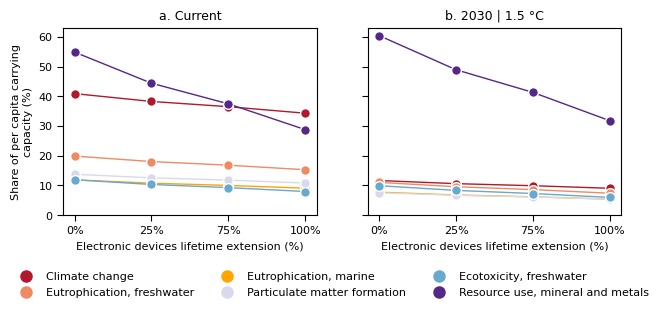

In [230]:
impact_color = ["#b2182b", "#ef8a62", "orange", "#d8daeb", "#67a9cf", "#542788"]

fig, axs = plt.subplots(1, 2, figsize=(fig_length[2], fig_height*0.25), sharey=True)

counter = 0
for sc in [SA_lcia_carrying_capacity_Default,
          # SA_lcia_carrying_capacity_Base,
          # SA_lcia_carrying_capacity_RCP26,
           SA_lcia_carrying_capacity_RCP19]:
    sc.loc[categories_prospective].T.plot(ax=axs[counter], fontsize=fontsize_axs, color=impact_color, lw=1, ls="-",
                                          marker='o', ms=7, mec="white", legend=False, zorder=2)

    axs[counter].tick_params(axis='x', which='major', direction='out', length=4, labelsize=fontsize_axs)
    axs[counter].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
    axs[counter].yaxis.offsetText.set_fontsize(fontsize_axs)
    axs[counter].set_xticks([0,1,2,3])
   # axs[counter].set_xlim(0, 3)
    
    axs[counter].set_xticklabels(["0%", "25%", "75%", "100%"], fontsize=fontsize_axs)

    axs[counter].set_xlabel('Electronic devices lifetime extension (%)', fontsize=fontsize_label)

    counter += 1

axs[0].set_title("a. Current", loc='center', fontsize=fontsize_title)
axs[1].set_title("b. 2030 | 1.5 °C", loc='center', fontsize=fontsize_title)


axs[0].set_ylabel('Share of per capita carrying\ncapacity (%)', fontsize=fontsize_label)
axs[0].set_ylim(0, 63)

# LEGEND
patch_1 = Line2D([0], [0], color=impact_color[0], label=categories_prospective[0], ls='None', marker='o', ms=8)
patch_2 = Line2D([0], [0], color=impact_color[1], label=categories_prospective[1], ls='None', marker='o', ms=8)
patch_3 = Line2D([0], [0], color=impact_color[2], label=categories_prospective[2], ls='None', marker='o', ms=8)
patch_4 = Line2D([0], [0], color=impact_color[3], label=categories_prospective[3], ls='None', marker='o', ms=8)
patch_5 = Line2D([0], [0], color=impact_color[4], label=categories_prospective[4], ls='None', marker='o', ms=8)
patch_6 = Line2D([0], [0], color=impact_color[5], label=categories_prospective[5], ls='None', marker='o', ms=8)

axs[0].legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5, patch_6], 
                bbox_to_anchor=(2.35,-0.25), ncol=3, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)


plt.savefig(Path(str(r"..\reports\submission") + '/fig_5.jpg'), dpi=600, bbox_inches='tight')